In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nilearn

In [ ]:
import os
import cv2
import glob
import random
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt



# ml libs
import keras
import keras.backend as K
# from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# Define classes, slices and Image size
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'tumor'
}
VOLUME_SLICES = 100 # Total slices to consider
VOLUME_START_AT = 25 # Slice starts at

IMG_SIZE=128

In [ ]:
# Define paths to the BraTS and ATLAS dataset

path = '/content/drive/MyDrive/Thesis/'
TRAIN_DATASET_PATH = path + 'Datasets/BraTS2021_Dataset/BraTS2021_Training_Data'
VALIDATION_DATASET_PATH = path + 'Datasets/BraTS2021_Dataset/BraTS2021_Validation_Data'
TRAIN_DATASET_PATH_ATLAS = path + 'Datasets/ATLAS_2/Training/'

In [ ]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00003/BraTS2021_00003_t1.nii.gz').get_fdata()

test_mask=nib.load(TRAIN_DATASET_PATH + '/BraTS2021_00003/BraTS2021_00003_seg.nii.gz').get_fdata()

print(test_image_t1.shape)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 10))
slice_w = 25

ax1.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image t1')

ax2.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax2.set_title('Mask')

In [ ]:
# Show whole nifti data -> print each slice from 3d data
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

In [ ]:
# Show segment of tumor for each above slice
# Skip 60:-60 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [ ]:
# dice loss for the 2 classes

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


 
# define per class evaluation of dice coef
def dice_coef_tumor(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)



# Metrics used for Computing Sensitivity, Specificity, Precision 

    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    

In [ ]:
# Load directories containing studies
train_and_val_directories = [f.path.replace("\\","/") for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories_atlas = []

# Load directories containing atlas files
for r in os.scandir(TRAIN_DATASET_PATH_ATLAS):
    if r.is_dir():
        f = r.path.replace("\\","/")
        for i in os.scandir(f):
            if i.is_dir():
                train_and_val_directories_atlas.append(i.path.replace("\\","/")+"/ses-1/anat")

# Convert list of directory paths to list of study IDs
def IDsofPath(dirList, dirListAtlas):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    for i in range(0, len(dirListAtlas)):
        x.append('/'.join(train_and_val_directories_atlas[i].split('/')[8:]))
    return x

# Convert directory paths to study IDs
TrainTestIds = IDsofPath(train_and_val_directories, train_and_val_directories_atlas)

# Shuffle and split the data into training, validation, and test sets
random.shuffle(TrainTestIds)
train_test_ids, val_ids = train_test_split(TrainTestIds,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [ ]:
# Data generator for Keras
class DataGenerator(keras.utils.Sequence):
    
    # Initialization function
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size=1, n_channels=1, shuffle=True):
        self.dim = dim  # dimension of each slice
        self.batch_size = batch_size  # batch size
        self.list_IDs = list_IDs  # list of IDs
        self.n_channels = n_channels  # number of channels
        self.shuffle = shuffle  # shuffle the dataset
        self.on_epoch_end()  # updates indexes after each epoch

    # Returns the number of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    # Generate one batch of data
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    # Updates indexes after each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # Generate data containing batch_size samples
    def __data_generation(self, Batch_ids):
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 197, 233))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 2))

        # Generate data
        for c, i in enumerate(Batch_ids):
            if 'anat' in i:
                val1, val2 = 0, 197
                case_path = os.path.join(TRAIN_DATASET_PATH_ATLAS, i)
                n = i.split('/')[1]
                
                data_path = os.path.join(case_path, f'{n}_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz')
                seg = nib.load(data_path.replace("\\","/")).get_fdata()

                data_path = os.path.join(case_path, f'{n}_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz')
                t1 = nib.load(data_path.replace("\\","/")).get_fdata()
                
            else:
                val1, val2 = 21, 218
                case_path = os.path.join(TRAIN_DATASET_PATH, i)

                data_path = os.path.join(case_path, f'{i}_t1.nii.gz')
                t1 = nib.load(data_path.replace("\\","/")).get_fdata()

                data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
                seg = nib.load(data_path.replace("\\","/")).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j +VOLUME_SLICES*c] = seg[val1:val2,:233,j+VOLUME_START_AT]

            # Generate masks
            y[y==2] = 1
            y[y==3] = 1
            y[y==4] = 1            
            mask = tf.one_hot(y, 2)
            Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        return X/np.max(X), Y


# generator for training, validation and testing data    

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [ ]:
# Display Train, Val and Test dataset size

def DataFigure():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','blue', 'red'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
DataFigure()

In [ ]:
# call back for training

csv_logger = CSVLogger(path + 'logs/training.log', separator=',', append=False)


callbacks = [
    EarlyStopping(monitor='loss', min_delta=0,
                              patience=2, verbose=1, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath = 'Models/Modelcheckpoint/model_.{epoch:02d}-{val_loss:.6f}.m5',
                            verbose=1, save_best_only=True, save_weights_only = True),
   csv_logger
    ]

In [ ]:
# U-Net architecture

def unet_arch(inputs, ker_init, dropout):

    conv1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(64, 1, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    conv10 = Conv2D(2, (1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)


input_layer = Input((IMG_SIZE, IMG_SIZE, 1))

model = unet_arch(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, precision, sensitivity, 
                         specificity, dice_coef_tumor] )

In [ ]:
# plot model architecture

plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:
# MODEL TRAINING 


K.clear_session()

history =  model.fit(training_generator,
                    epochs=10,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save(path + "Models/model_singleinput_colabrun_2.h5")

In [ ]:
# Loading the trained model

model = keras.models.load_model(path + 'Models/model_singleinput_colabrun_2.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_tumor": dice_coef_tumor
                                                  }, compile=False)

In [ ]:
# Plot training loss and testing loss

history = pd.read_csv(path + 'logs/training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']


f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


R004/sub-r004s027/ses-1/anat
4/4 [==============================] - 5s 978ms/step
[4472281, 117819, 0, 0, 0]
[0, 0, 0, 0, 0]
46.854373812675476


<Figure size 1296x3600 with 0 Axes>

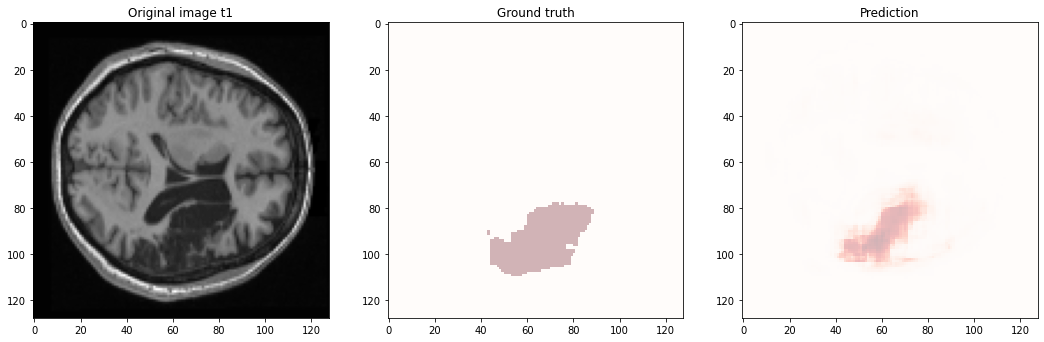

R047/sub-r047s026/ses-1/anat
4/4 [==============================] - 5s 1s/step
[4439688, 150412, 0, 0, 0]
[0, 0, 0, 0, 0]
48.85560870170593


<Figure size 1296x3600 with 0 Axes>

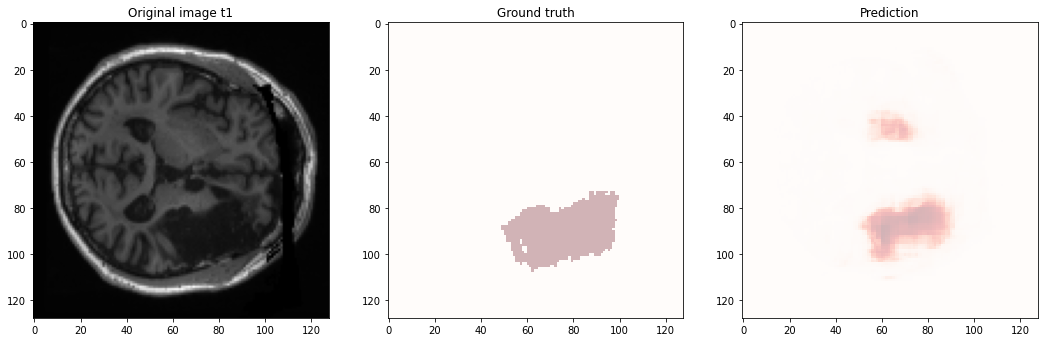

R011/sub-r011s032/ses-1/anat
4/4 [==============================] - 6s 1s/step
[4588874, 1226, 0, 0, 0]
[0, 0, 0, 0, 0]
3.8963984698057175


<Figure size 1296x3600 with 0 Axes>

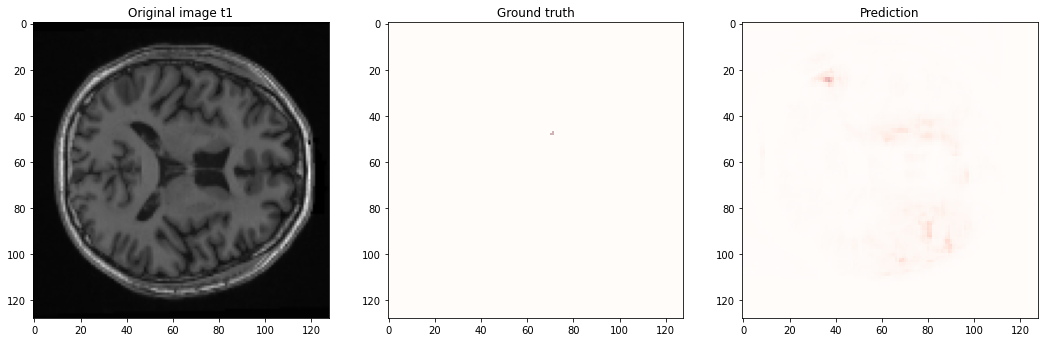

4/4 [==============================] - 5s 1s/step
[4536664, 15229, 27675, 0, 10532]
[0, 0, 0, 0, 0]
47.53086864948273


<Figure size 1296x3600 with 0 Axes>

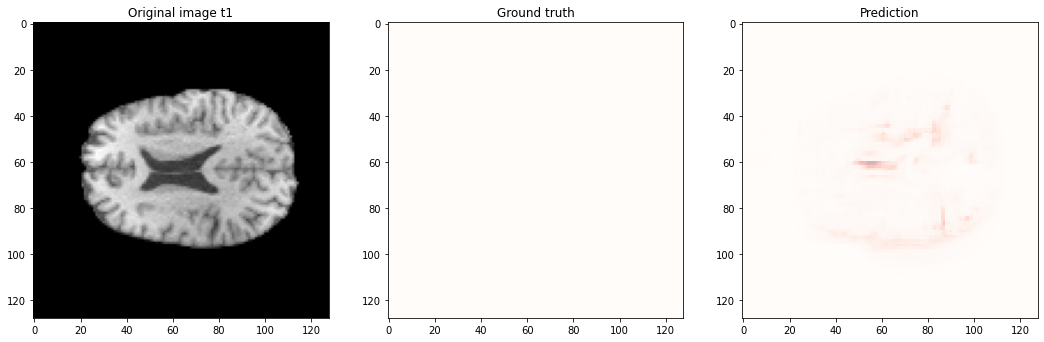

4/4 [==============================] - 4s 830ms/step
[4558185, 1729, 20451, 0, 9735]
[0, 0, 0, 0, 0]
35.43896973133087


<Figure size 1296x3600 with 0 Axes>

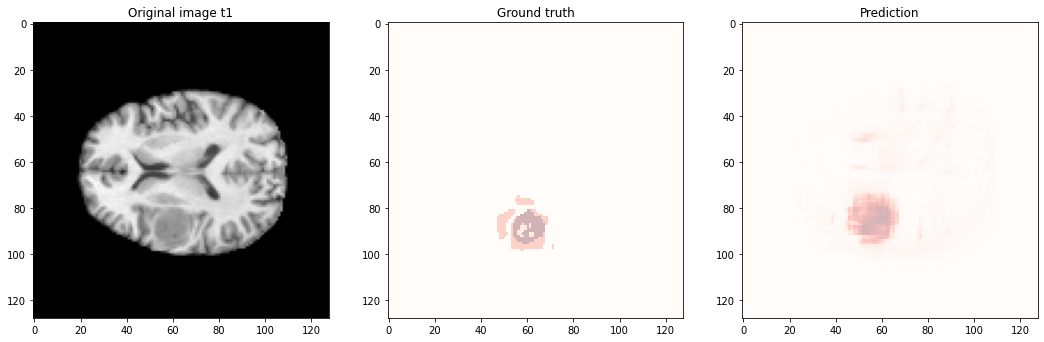

R048/sub-r048s010/ses-1/anat
4/4 [==============================] - 4s 964ms/step
[4588680, 1420, 0, 0, 0]
[0, 0, 0, 0, 0]
3.3404096961021423


<Figure size 1296x3600 with 0 Axes>

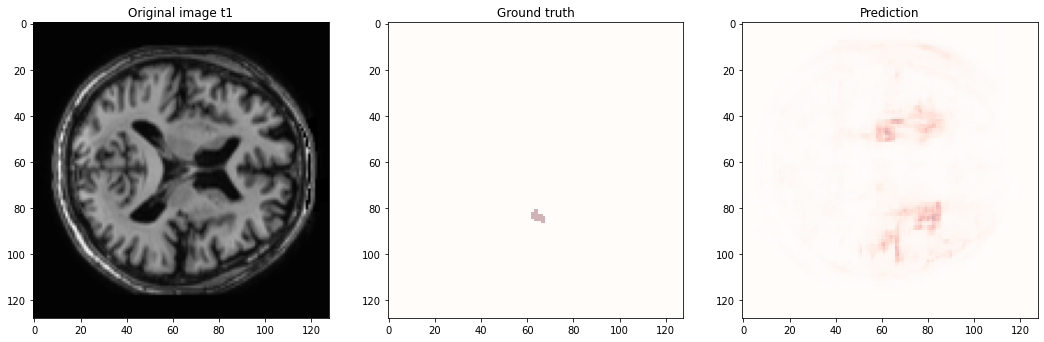

4/4 [==============================] - 5s 1s/step
[4545581, 7469, 27590, 0, 9460]
[0, 0, 0, 0, 0]
17.410632967948914


<Figure size 1296x3600 with 0 Axes>

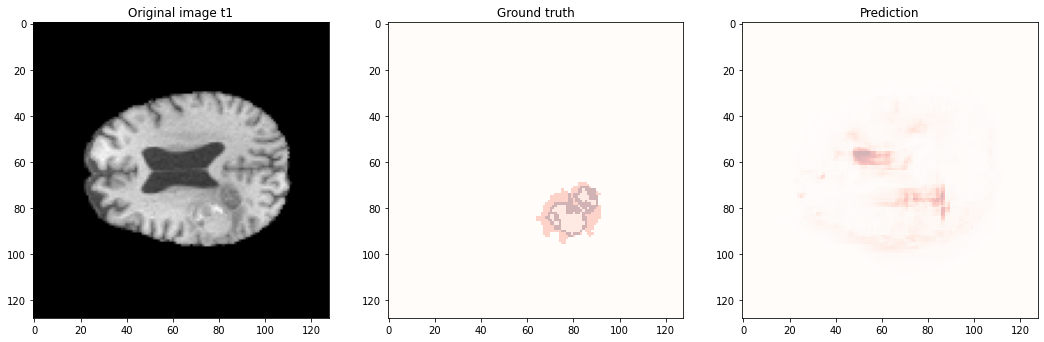

In [ ]:
# Define the function to predict the brain tumor masks from a given 3D brain volume
def predictImgPath(t1):
    # Create an empty numpy array to store the input data
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 1))
    
    # Resize and append each slice of the 3D brain volume to the input data numpy array
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Normalize the input data and predict the output using the trained model
    return model.predict(X/np.max(X), verbose=1)


# Define the function to display the ground truth and predicted brain tumor masks for a given brain volume
def DisplayPredictionById(case, start_slice = 60):
    
    # Check if the given brain volume belongs to the atlas dataset or the BraTS dataset
    if 'anat' in case:
        val1, val2 = 0, 197
        print(case)
        case_path = os.path.join(TRAIN_DATASET_PATH_ATLAS, case)
        n = case.split('/')[1]
        
        # Load the ground truth brain tumor mask and the original brain volume from the atlas dataset
        data_path = os.path.join(case_path, f'{n}_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz')
        gt = nib.load(data_path.replace("\\","/")).get_fdata()

        data_path = os.path.join(case_path, f'{n}_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz')
        origImage = nib.load(data_path.replace("\\","/")).get_fdata()
        
    else:
        val1, val2 = 21, 218
        case_path = os.path.join(TRAIN_DATASET_PATH, case)
    
        # Load the ground truth brain tumor mask and the original brain volume from the BraTS dataset
        data_path = os.path.join(case_path, f'{case}_t1.nii.gz')
        origImage = nib.load(data_path.replace("\\","/")).get_fdata()

        data_path = os.path.join(case_path, f'{case}_seg.nii.gz')
        gt = nib.load(data_path.replace("\\","/")).get_fdata()
    
    # Predict the brain tumor mask using the trained model
    p = predictImgPath(origImage)

    # Create a numpy array to store the ground truth brain tumor mask
    y = np.zeros((VOLUME_SLICES, 197, 233))
    for j in range(VOLUME_SLICES):
        y[j] = gt[val1:val2,:233,j+VOLUME_START_AT]

    # Print the number of pixels in each class of the ground truth brain tumor mask and the predicted brain tumor mask
    print([len(y[y==0]), len(y[y==1]), len(y[y==2]), len(y[y==3]), len(y[y==4])])
    print([len(p[p==0]), len(p[p==1]), len(p[p==2]), len(p[p==3]), len(p[p==4])])

    
    y[y==2] = 1
    y[y==3] = 1
    y[y==4] = 1            
    mask = tf.one_hot(y, 2)
    Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Calculate the dice coefficient for the predicted brain tumor mask and the binary mask of the ground truth brain tumor mask
    out = dice_coef_tumor(Y, p)
    print(out.numpy()*100)

    # Display the ground truth brain tumor mask, the predicted brain tumor mask, and the original brain volume for the given slice
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,3, figsize = (18, 50)) 

    # for i in range(3): # for each image, add brain background
    #     axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image t1')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('Prediction')
    plt.show()
    
    
DisplayPredictionById(case=test_ids[10])
DisplayPredictionById(case=test_ids[1])
DisplayPredictionById(case=test_ids[12])
DisplayPredictionById(case=test_ids[13])
DisplayPredictionById(case=test_ids[14])
DisplayPredictionById(case=test_ids[15])
DisplayPredictionById(case=test_ids[16])

In [ ]:
def predictDataset(dataset):

  out_list = []

  for case in dataset:
    
    if 'anat' in case:
        val1, val2 = 0, 197
        case_path = os.path.join(TRAIN_DATASET_PATH_ATLAS, case)
        n = case.split('/')[1]
        
        data_path = os.path.join(case_path, f'{n}_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz')
        gt = nib.load(data_path.replace("\\","/")).get_fdata()

        data_path = os.path.join(case_path, f'{n}_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz')
        origImage = nib.load(data_path.replace("\\","/")).get_fdata()
        
    else:
        val1, val2 = 21, 218
        case_path = os.path.join(TRAIN_DATASET_PATH, case)
    
        data_path = os.path.join(case_path, f'{case}_t1.nii.gz')
        origImage = nib.load(data_path.replace("\\","/")).get_fdata()

        data_path = os.path.join(case_path, f'{case}_seg.nii.gz')
        gt = nib.load(data_path.replace("\\","/")).get_fdata()
    
    p = predictImgPath(origImage)

    y = np.zeros((VOLUME_SLICES, 197, 233))
    for j in range(VOLUME_SLICES):
        y[j] = gt[val1:val2,:233,j+VOLUME_START_AT]
    
    y[y==2] = 1
    y[y==3] = 1
    y[y==4] = 1            
    mask = tf.one_hot(y, 2)
    Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    out = dice_coef_tumor(Y, p)
    out_list.append(out.numpy()*100)

  return out_list
  
output = predictDataset(test_ids)


In [ ]:
output_val = predictDataset(val_ids)